## Overview

### External Interface Requirements
1. Input requirement: capacity to read a dataset stored on disk.
2. Output requirement: report on optimal number of clusters, centroid coordinates and quality metric.
3. Output requirement: identifiers of classes corresponding to new instances classified by the model.

### Functional Requirements
1. The software must learn a clusterization a the dataset.
2. The software must use the learned clusterization to classify new problem instances.
3. The software must evaluate the quality of a clusterization.
4. The software must be flexible to work with different preconfigured amount of clusters.
5. The software must compare results using different numbers of clusters and determine which number of clusters is best.


### Necessary Deliverables
1. Python application that performs ETL, training, and testing.
2. Report containing quality metrics, and explanation of the dataset, and the experimental procedure (range of the different number of clusters that were tested, how the range was traversed, etc.).

### Further notes
	- Find data & understand it (sometimes need to aggregate rows of data as each line is not unique) 
    - Perform data cleaning&feature engineering 
	- First find all different clusters (types) of clients/products 
	- 2nd find their characteristics 

In [374]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

In [375]:
taxi = pd.read_csv('../data/train.csv')

### Exploring the data & variables

In [376]:
taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [377]:
taxi.shape

(1458644, 11)

In [378]:
len(taxi.id.unique())

1458644

In [379]:
taxi.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [380]:
taxi.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [381]:
missing = taxi.isnull().sum()
missing

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

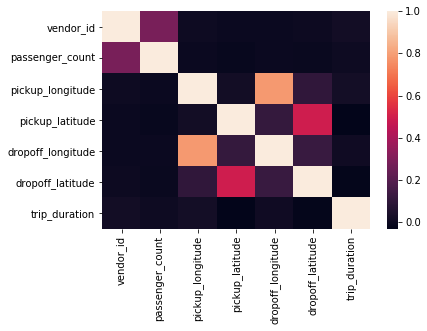

In [382]:
sns.heatmap(taxi.corr())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1ad24cd828>,
      dtype=object)

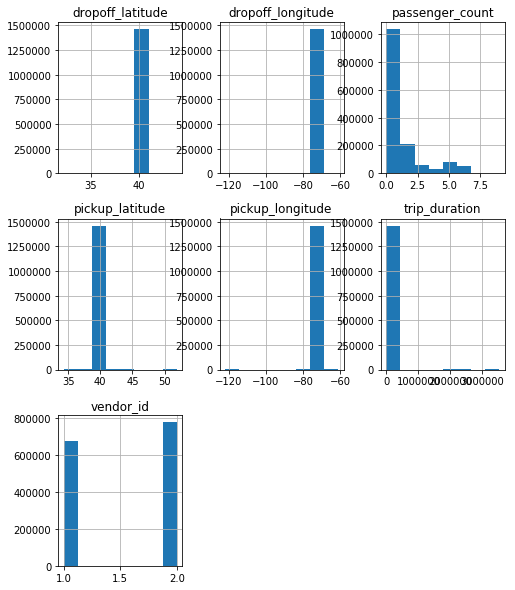

In [383]:
taxi.hist(figsize=(8,10), bins=8)

In [384]:
taxi.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [385]:
taxi.trip_duration.max(), taxi.trip_duration.min()

(3526282, 1)

In [386]:
print('max hours: ' , 3526282/60/60)

max hours:  979.5227777777778


Check for any trips longer than 10 h

In [387]:
taxi[taxi.trip_duration > 36000]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594
1134,id1091477,2,2016-05-07 18:36:22,2016-05-08 18:32:11,1,-73.990242,40.750919,-73.976280,40.750889,N,86149
1865,id3431345,2,2016-06-07 12:58:48,2016-06-08 12:58:00,6,-73.954956,40.777649,-73.981033,40.743713,N,86352
3442,id1487069,2,2016-02-13 00:21:49,2016-02-14 00:19:05,1,-73.968590,40.799217,-73.979584,40.784714,N,86236
4172,id3674870,2,2016-03-18 11:54:20,2016-03-19 11:34:17,1,-73.989090,40.736992,-73.972336,40.751511,N,85197
4336,id3632390,2,2016-06-08 08:54:33,2016-06-09 07:58:09,5,-73.980560,40.742466,-73.984718,40.748611,N,83016
5104,id3354426,2,2016-05-05 15:18:41,2016-05-06 15:11:07,1,-73.989037,40.773514,-73.980682,40.781521,N,85946
5778,id0773526,2,2016-04-02 14:58:45,2016-04-03 14:19:55,6,-73.987991,40.761341,-74.002922,40.756279,N,84070
6132,id3617210,2,2016-03-15 17:51:32,2016-03-16 17:18:04,1,-73.965607,40.765781,-73.972649,40.753418,N,84392
6513,id0067152,2,2016-02-27 21:04:05,2016-02-28 21:03:22,5,-73.993744,40.727444,-74.001335,40.729244,N,86357


There are > 2000 rows with trip duration longer than 10h; will drop as outliers (initially they were kept in the df and when running the model, clustering created 2 clusters with long trip durations and there were only 2-3 values in each cluster, so clearly these values are not helping the model)

In [388]:
taxi.store_and_fwd_flag.value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [389]:
taxi.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

Might drop the 2 columns above as they are not significant for the clustering

### Cleaning the data

Convert pick up and drop off dates to datetime

In [390]:
taxi.pickup_datetime = pd.to_datetime(taxi.pickup_datetime)
taxi.dropoff_datetime = pd.to_datetime(taxi.dropoff_datetime)

In [391]:
taxi.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object

Feature engineering on datetime

In [392]:
taxi['pickup_hour'] = taxi.pickup_datetime.dt.hour
taxi['pickup_day'] = taxi.pickup_datetime.dt.day_name()
taxi['dropoff_hour'] = taxi.dropoff_datetime.dt.hour
taxi['dropoff_day'] = taxi.dropoff_datetime.dt.day_name()

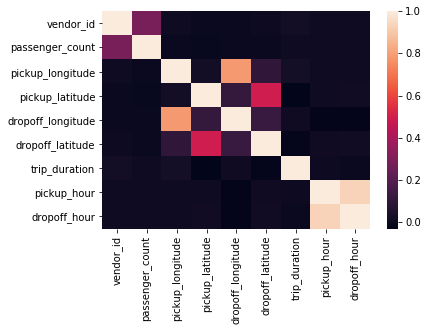

In [393]:
sns.heatmap(taxi.corr())

Will drop all dropoff time information as it's highly correlated to the pickup time and moreover we already have a column with trip duration; drop pick up datetime as well since we now have the hour & day columns

In [394]:
taxi_drop = taxi.copy()
taxi_drop.drop(['dropoff_datetime', 'dropoff_hour', 'dropoff_day', 'pickup_datetime'], inplace=True, axis=1)

Drop drop off longitude which is quite highly correlated to pickup longitude & drop the store_and_fwd_flag & vendor_id columns as they are not significant for the clustering

In [395]:
taxi_drop.drop(['dropoff_longitude', 'store_and_fwd_flag', 'vendor_id'], inplace=True, axis=1)

Drop the rows with trip duration > 10h 

In [396]:
taxi_drop = taxi_drop[taxi_drop.trip_duration < 36000]

Check the pick up hour & day values

In [397]:
taxi_drop.pickup_day.value_counts()

Friday       223206
Saturday     220488
Thursday     218290
Wednesday    209894
Tuesday      202489
Sunday       195043
Monday       187222
Name: pickup_day, dtype: int64

In [398]:
taxi_drop.pickup_hour.value_counts()

18    90473
19    90197
21    84072
20    83964
22    80348
17    76396
14    74183
12    71772
15    71687
13    71352
23    69692
11    68400
9     67589
8     66980
10    65369
16    64229
7     55549
0     53171
1     38496
6     33221
2     27909
3     20847
4     15756
5     14980
Name: pickup_hour, dtype: int64

Do one hot encoding on day field to transfor the categorical variable

In [399]:
taxi_days = pd.get_dummies(data=taxi_drop, columns=['pickup_day'])

In [400]:
taxi_days = taxi_days.set_index('id')

In [401]:
principalDf = taxi_days.copy()

### PCA

???

In [402]:
# from sklearn.decomposition import PCA 

# pca = PCA(n_components=4) 
# principalComponents = pca.fit_transform(taxi_days) 
# principalDf = pd.DataFrame(data = principalComponents ,columns = ['pc1', 'pc2', 'pc3', 'pc4']) 
# principalDf.head()

### K-Means Clustering

???

In [403]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
taxi_clusters = kmeans.fit(principalDf)
taxi_clusters.cluster_centers_

array([[ 1.64909514e+00, -7.39788126e+01,  4.07543098e+01,
         4.07551451e+01,  3.98081722e+02,  1.34206357e+01,
         1.47614034e-01,  1.35126522e-01,  1.58151843e-01,
         1.47548148e-01,  1.39141566e-01,  1.35429062e-01,
         1.36988825e-01],
       [ 1.73169099e+00, -7.38949285e+01,  4.07171947e+01,
         4.07278336e+01,  3.34279939e+03,  1.40579195e+01,
         1.77568409e-01,  1.29456586e-01,  8.65189075e-02,
         9.96473344e-02,  1.93090844e-01,  1.44155276e-01,
         1.69562643e-01],
       [ 1.68824811e+00, -7.39561976e+01,  4.07443004e+01,
         4.07431297e+01,  1.76171968e+03,  1.38053453e+01,
         1.60555455e-01,  1.15927947e-01,  1.34096078e-01,
         1.09969782e-01,  1.72012642e-01,  1.47058824e-01,
         1.60379272e-01],
       [ 1.84615385e+00, -7.39584449e+01,  4.06961980e+01,
         4.07393437e+01,  2.61710923e+04,  1.56000000e+01,
         1.69230769e-01,  1.69230769e-01,  1.38461538e-01,
         1.07692308e-01,  1.38461538e

In [404]:
taxi_days['labels'] = taxi_clusters.fit_predict(principalDf) 
taxi_days.reset_index('id', inplace=True) 
taxi_merged = pd.merge(taxi, taxi_days[['id', 'labels']], on='id', how='outer') 
taxi_merged.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day,dropoff_hour,dropoff_day,labels
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,Monday,17,Monday,0.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,Sunday,0,Sunday,0.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,Tuesday,12,Tuesday,2.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,Wednesday,19,Wednesday,0.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,Saturday,13,Saturday,0.0


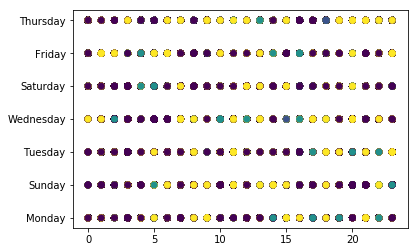

In [405]:
plt.scatter(x=taxi_merged["pickup_hour"], y=taxi_merged["pickup_day"], c=taxi_merged["labels"])

In [406]:
taxi_merged.labels.value_counts()

0.0    744684
4.0    485730
2.0    187359
1.0     38794
3.0        65
Name: labels, dtype: int64

In [407]:
pd.crosstab(taxi_days.pickup_hour, taxi_days.labels)

labels,0,1,2,3,4
pickup_hour,,,,,
0,27905,495,6872,0,17899
1,21350,295,4121,0,12730
2,16059,134,2515,0,9201
3,11931,91,1897,0,6928
4,8623,87,1855,0,5191
5,9106,143,1938,0,3793
6,22576,802,2613,0,7230
7,32864,1433,4798,0,16454
8,34303,1847,8395,0,22435


In [408]:
taxi_group = taxi.groupby(['id','pickup_day']).sum() 

In [409]:
taxi_group.head()

,,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_hour,dropoff_hour
id,pickup_day,,,,,,,,,
id0000001,Tuesday,2,1,-74.013924,40.713924,-73.971649,40.746407,1105,10,11
id0000003,Wednesday,2,5,-73.990753,40.754761,-74.007118,40.741531,1046,10,10
id0000005,Monday,2,1,-73.953110,40.798580,-73.968178,40.800270,368,9,9
id0000008,Wednesday,1,1,-74.009628,40.724762,-74.015869,40.715485,303,9,10
id0000009,Sunday,1,1,-73.987991,40.759899,-73.959686,40.798504,547,1,1


In [410]:
pd.crosstab(taxi_group.pickup_day, taxi_days.labels)

AttributeError: 'DataFrame' object has no attribute 'pickup_day'

### Hierarchical clustering

### DBscan

### Gausian mixture model